In [1]:
#  article dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
#from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random

In [2]:
#  setting up device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [10]:
import os
import cv2
from natsort import natsorted

class Data():

    def __init__(self):
        pass

    def get_images(images_path):
    # speichert Bilder als numpy array

        array_images = []
        train_or_test_folder = os.listdir(images_path)

        for folder in natsorted(train_or_test_folder):
            single_folder = os.path.join(images_path, folder)

            for file in os.listdir(single_folder):
                filepath = os.path.join(single_folder, file)

                if filepath.lower().endswith(('.jpeg', '.jpg')):
                    image = cv2.resize(cv2.imread(filepath), (64, 64))  # resize Größe bestimmt durch vortainiertes Netz
                    array_images.append(image)

        images = np.array(array_images)
        
        return images
    
    def get_label(images_path):
    # speichert Lables als numpy array

        array_label = []
        for folder in natsorted(os.listdir(images_path)):
            label = int(folder)

            for file in os.listdir(os.path.join(images_path, folder)):
                array_label.append(label)
        labels = np.array(array_label)
            
        return labels
    
images = Data.get_images("../../02_data_crop/train")
labels = Data.get_label("../../02_data_crop/train") # train images

X_eval = Data.get_images("../../02_data_crop/test")
y_eval = Data.get_label("../../02_data_crop/test")  # Evaluierungs Bilder

In [11]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

uniq_labels = natsorted(os.listdir("../../02_data_crop/train"))
print("Anzahl eindeutiger Klassen: {}".format(len(uniq_labels)))

# Trainingsbilder, Testbilder, Trainingslabels, Testlabels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)
# von jeder Klasse Daten

n = len(uniq_labels)   # Anzahl eindeutiger Klassen
train_n = len(X_train) # Anzahl Trainingsdaten
test_n = len(X_test)   # Anzahl Testdaten
eval_n = len(X_eval)

tab = [['Klassen:',n],
       ['Trainingsbilder', train_n],['Testbilder', test_n],['Evaluierungsbilder', eval_n]]

print(tabulate(tab, headers=["Anzahl", "Wert"]))

Anzahl eindeutiger Klassen: 26
Anzahl                Wert
------------------  ------
Klassen:                26
Trainingsbilder       8294
Testbilder            2074
Evaluierungsbilder    1448


In [5]:
import keras
# one hot encoding der Labels
# Binarisierung, entsprechende Klasse mit 1 gekennzeichnet
#y_train = keras.utils.to_categorical(y_train)
#y_test = keras.utils.to_categorical(y_test)
#y_eval = keras.utils.to_categorical(y_eval)

In [12]:
import torch
from torch.utils.data import Dataset

class PyTorchDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Erstellen des CustomDataset
training_dataset = PyTorchDataset(images=X_train, labels=y_train, transform=transforms.Compose([transforms.ToTensor(),
                                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_dataset = PyTorchDataset(images=X_test, labels=y_test, transform=transforms.Compose([transforms.ToTensor(),
                                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
eval_dataset = PyTorchDataset(images=X_eval, labels=y_eval, transform=transforms.Compose([transforms.ToTensor(),
                                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [13]:
num_training = len(training_dataset)
num_test = len(test_dataset) 
num_eval = len(eval_dataset)   
image_train, label_train = training_dataset[1]
shape = image_train.shape
type = image_train.type

tab = [['Trainingsbilder: ', num_training],['Testbilder: ', num_test],['Evaluierungsbilder: ', num_eval],
       ['Shape: ', shape], ['Type: ', type]]

print(tabulate(tab, headers=["Kenngröße", "Wert"]))

Kenngröße            Wert
-------------------  -------------------------------------------------------------
Trainingsbilder:     8294
Testbilder:          2074
Evaluierungsbilder:  1448
Shape:               torch.Size([64, 64, 3])
Type:                <built-in method type of Tensor object at 0x00000211D24D7A70>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


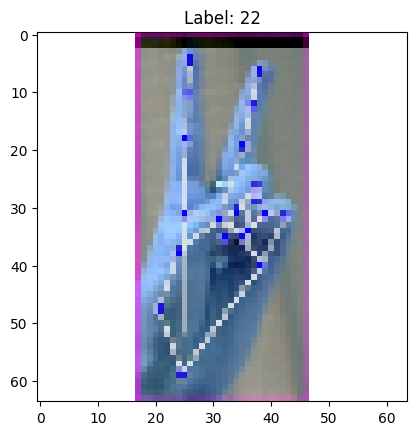

In [14]:
# Anzeigen des Bildes
plt.imshow(image_train)
plt.title(f"Label: {label_train}")
plt.show()

In [22]:
#  creating a mock model
def mock_model(image_instance, batch_mode=False):
  """
  Diese Funktion erstellt ein Mock-Modell,
  bei dem alle Bilder als ein Label definiert wird.
  Damit wird eine accuracy erstellt, die so groß ist, 
  wie der Anteil der Bilder des gewählten Labels
  """
  if not batch_mode:
    classification = 0
    label = image_instance[1].item()
    print(f'model classification = {classification}\ntrue label = {label}')

  else:
    #  extracting true labels
    labels = [label for _, label in image_instance]
    labels = np.array(labels)

    #  classifying all instances as one class
    classifications = [1]*(len(image_instance))
    classifications = np.array(classifications)

    a = labels[0]
    b = labels.shape
    c = classifications.shape
    d = len(labels)

    tab = [['Label: ', a],['labels.shape: ', b], ['len(lables):', d], ['classifications.shape: ', c], ['', '']]

    print(tabulate(tab, headers=["Kenngröße", "Wert"]))

    #  computing accuracy
    accuracy = (sum(labels==classifications)/len(labels))
    print('model accuracy:', '\n')
    return round(accuracy, 3)
    

#  testing model in batch mode
mock_model(training_dataset, batch_mode=True)

     
#  testing model in batch mode
mock_model(eval_dataset, batch_mode=True)

Kenngröße               Wert
----------------------  -------
Label:                  15
labels.shape:           (8294,)
len(lables):            8294
classifications.shape:  (8294,)

model accuracy: 

Kenngröße               Wert
----------------------  -------
Label:                  1
labels.shape:           (1448,)
len(lables):            1448
classifications.shape:  (1448,)

model accuracy: 



0.074